# Final project: Is there a link between the types of restaurants in a city and the obesity rate?

### For all details on the data, methodology, results and observations, refer to the final report here: __https://github.com/faddy-ds/Coursera_Capstone__

## Step 1: Import all required libraries

In [81]:
pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /home/jupyterlab/conda/envs/python/lib/python3.6/site-packages (0.22.2.post1)
Note: you may need to restart the kernel to use updated packages.


In [82]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import folium

import requests

from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

## Step 2: Retrieve and analyze obesity data

In [83]:
# Create a dataframe and read data to it

obesity_rates_cities = pd.read_csv('Obesity data from CDC - 2011.csv')
obesity_rates_cities

,Area,Normal weight,Overweight,Obese,No physical activity
0,Akron-OH Metro Area,38.20%,32.50%,29.30%,22.60%
1,Albuquerque-NM Metro Area,43.30%,34.90%,21.70%,18.00%
2,Allentown-Bethlehem-Easton-PA-NJ Metro Area,37.50%,33.50%,29.00%,26.10%
3,Amarillo-TX Metro Area,35.00%,36.30%,28.70%,24.10%
4,Arcadia-FL Micropolitan Area,32.20%,33.70%,34.10%,35.10%
...,...,...,...,...,...
189,Worcester-MA Metro Area,39.10%,35.80%,25.20%,19.00%
190,Yakima-WA Metro Area,31.60%,37.00%,31.40%,25.10%
191,Youngstown-Warren-Boardman-OH-PA Metro Area,29.70%,35.50%,34.80%,26.40%
192,NaN,NaN,NaN,NaN,NaN


In [84]:
# Clean dataframe by deleting rows with NaN or missing data & formatting first column to separate City and State

obesity_rates_cities.dropna(inplace=True)
obesity_rates_cities.drop(columns=['No physical activity'], inplace=True)
obesity_rates_cities.reset_index(drop=True, inplace=True)

for i in range(len(obesity_rates_cities['Area'])):
    x = obesity_rates_cities['Area'].str.rsplit(" ", 2)[i][0]
    y = x.split("-")[0]
    z = x[-2:]
    obesity_rates_cities['Area'][i] = y + ", " + z
    obesity_rates_cities['Normal weight'][i] = obesity_rates_cities['Normal weight'].str.split("%")[i][0]
    obesity_rates_cities['Overweight'][i] = obesity_rates_cities['Overweight'].str.split("%")[i][0]
    obesity_rates_cities['Obese'][i] = obesity_rates_cities['Obese'].str.split("%")[i][0]

obesity_rates_cities.set_index('Area', inplace=True)
cols = obesity_rates_cities.columns
obesity_rates_cities[cols] = obesity_rates_cities[cols].apply(pd.to_numeric, downcast='float', errors='coerce')
# obesity_rates_cities.sort_values(by=['Obese'], inplace = True)

obesity_rates_cities

,Normal weight,Overweight,Obese
Area,,,
"Akron, OH",38.200001,32.500000,29.299999
"Albuquerque, NM",43.299999,34.900002,21.700001
"Allentown, NJ",37.500000,33.500000,29.000000
"Amarillo, TX",35.000000,36.299999,28.700001
"Arcadia, FL",32.200001,33.700001,34.099998
...,...,...,...
"Wichita, KS",38.500000,34.400002,27.100000
"Wilmington, NJ",35.500000,34.200001,30.400000
"Worcester, MA",39.099998,35.799999,25.200001


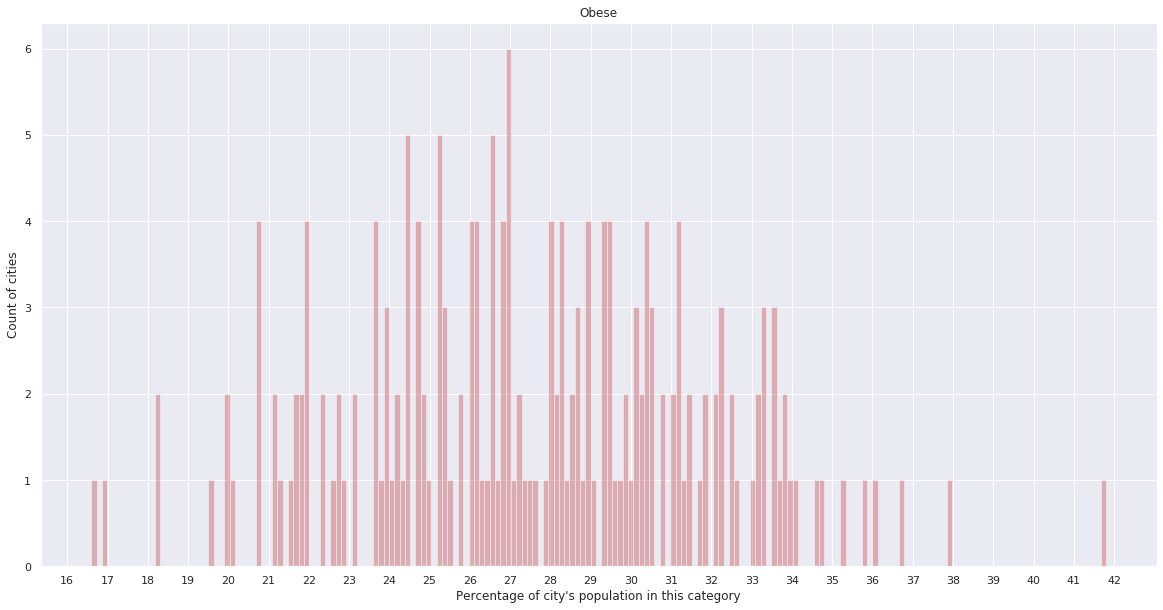

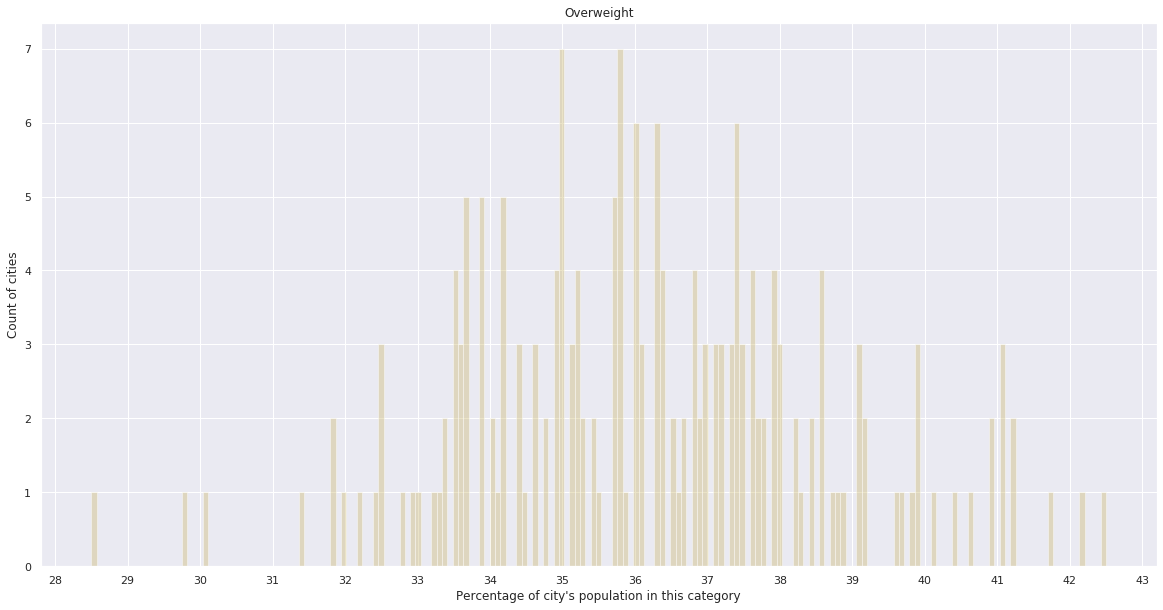

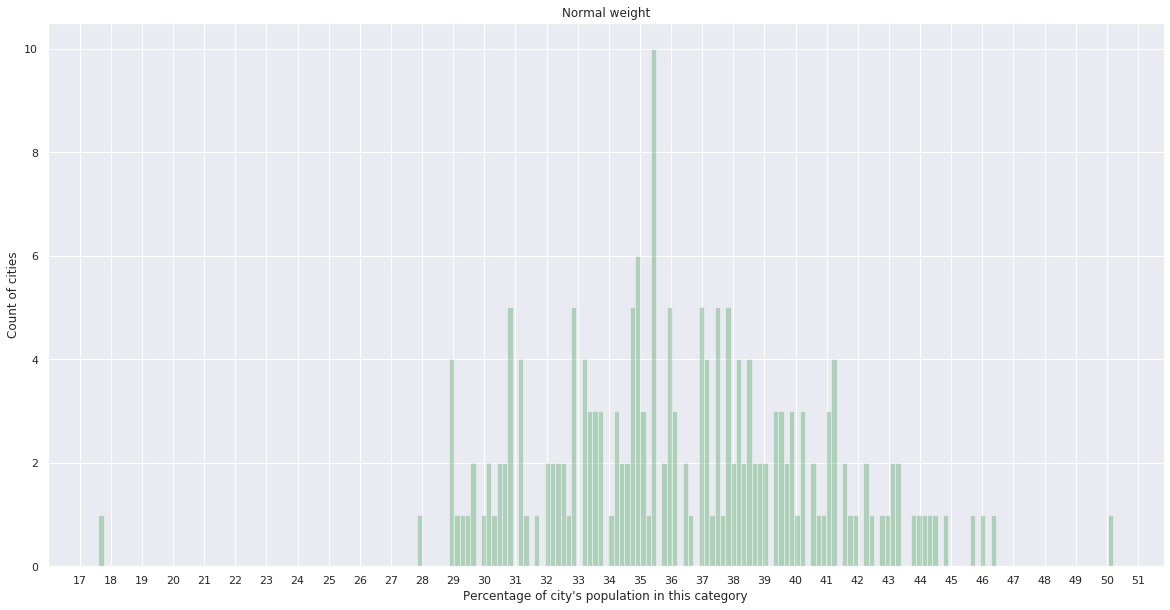

In [85]:
# Visualize the statistical distribution of data

sns.set(color_codes=True)

fig_ob, ax_ob = plt.subplots(figsize = (20,10))
sns.distplot(obesity_rates_cities['Obese'], color = 'r', kde=False, bins = 191).set_title('Obese')
ax_ob.set(xlabel = "Percentage of city's population in this category", ylabel = 'Count of cities')
plt.setp(ax_ob, xticks = [i for i in range(int(min(obesity_rates_cities['Obese'])), int(max(obesity_rates_cities['Obese'])+2), 1)])

fig_ow, ax_ow = plt.subplots(figsize = (20,10))
sns.distplot(obesity_rates_cities['Overweight'], color = 'y', kde=False, bins = 191).set_title('Overweight')
ax_ow.set(xlabel = "Percentage of city's population in this category", ylabel = 'Count of cities')
plt.setp(ax_ow, xticks = [i for i in range(int(min(obesity_rates_cities['Overweight'])), int(max(obesity_rates_cities['Overweight'])+2), 1)])

fig_n, ax_n = plt.subplots(figsize = (20,10))
sns.distplot(obesity_rates_cities['Normal weight'], color = 'g', kde=False, bins = 191).set_title('Normal weight')
ax_n.set(xlabel = "Percentage of city's population in this category", ylabel = 'Count of cities')
plt.setp(ax_n, xticks = [i for i in range(int(min(obesity_rates_cities['Normal weight'])), int(max(obesity_rates_cities['Normal weight'])+2), 1)])

plt.show()

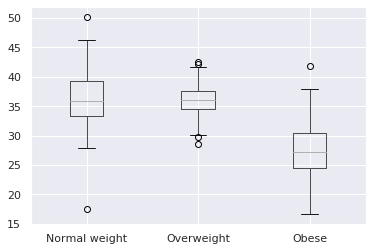

In [86]:
# Visualization of the data to identify outliers

obesity_rates_cities.boxplot()

In [87]:
# Get geographical coordiantes for the cities, using dataset from https://simplemaps.com/data/us-cities

city_coord = pd.read_csv('uscities.csv')
city_coord.dropna(inplace=True)
city_coord.drop(city_coord.columns.difference(['city', 'state_id', 'lat', 'lng']), 1, inplace=True)
city_coord['Area'] = city_coord['city'] + ', ' + city_coord['state_id']
city_coord.drop(columns = ['city', 'state_id'], inplace=True)
city_coord_keep = city_coord.loc[city_coord['Area'].isin(obesity_rates_cities.index)]
city_coord_keep.set_index('Area', inplace=True)
city_coord_keep.sort_index(inplace = True)
city_coord_keep

# There are only 160 rows, so 31 of the cities for which I have obesity data are not in the lat-long database

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,lat,lng
Area,,
"Akron, OH",41.0798,-81.5219
"Albuquerque, NM",35.1053,-106.6464
"Allentown, NJ",40.1777,-74.5873
"Amarillo, TX",35.1989,-101.8310
"Arcadia, FL",27.2214,-81.8587
...,...,...
"Wichita Falls, TX",33.9072,-98.5290
"Wichita, KS",37.6897,-97.3441
"Worcester, MA",42.2705,-71.8079


In [88]:
# Get lat-long data into obesity dataframe

data = pd.merge(obesity_rates_cities, city_coord_keep, left_index=True, right_index=True)
data.rename(columns = {'lat':'Latitude', 'lng':'Longitude'}, inplace = True)
data

,Normal weight,Overweight,Obese,Latitude,Longitude
Area,,,,,
"Akron, OH",38.200001,32.500000,29.299999,41.0798,-81.5219
"Albuquerque, NM",43.299999,34.900002,21.700001,35.1053,-106.6464
"Allentown, NJ",37.500000,33.500000,29.000000,40.1777,-74.5873
"Amarillo, TX",35.000000,36.299999,28.700001,35.1989,-101.8310
"Arcadia, FL",32.200001,33.700001,34.099998,27.2214,-81.8587
...,...,...,...,...,...
"Wichita Falls, TX",32.900002,39.200001,27.900000,33.9072,-98.5290
"Wichita, KS",38.500000,34.400002,27.100000,37.6897,-97.3441
"Worcester, MA",39.099998,35.799999,25.200001,42.2705,-71.8079


In [89]:
# Statistical analysis of the data

data.describe(include='all')

,Normal weight,Overweight,Obese,Latitude,Longitude
count,160.000000,160.000000,160.000000,160.000000,160.000000
mean,36.328754,36.235626,27.441875,37.057594,-92.798208
std,4.621789,2.518319,4.378614,6.404878,18.273823
min,17.600000,28.500000,16.600000,19.688600,-159.352000
25%,33.275000,34.599998,24.475000,32.324475,-103.936575
50%,35.800001,36.099998,27.550000,38.927000,-86.465050
75%,39.525000,37.700001,30.425000,41.983225,-80.343850
max,50.200001,42.500000,41.799999,48.237400,-68.790600


In [90]:
# Visualize the graphical distribution of data

us_map = folium.Map(location=[38, -115], zoom_start=4)

for lat, long, obese, area in zip(data['Latitude'], data['Longitude'], data['Obese'], data.index):
    label = '{}% of population in {} is obese'.format(obese, area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(us_map)

us_map

## Step 3: Compile most common restaurant categories per city

In [91]:
# Get 3 most common types of restaurants for each area

CLIENT_ID = 'UEHS0BUJQOPZQPPKWNBA1YZSCP3O14SZYGT1ZC0XECDCJFMG'
CLIENT_SECRET = '3AM1HHTVARNZV5VMLJKY25YQOXKYHC0M3R45IZL3QQ4LXB5S'
VERSION = '20180604'

# Below is a test with Akron, OH to test the query and results' format

LIMIT = 20
category = '4d4b7105d754a06374d81259'
intent = 'browse'
lat = data.iloc[0, 3]
long = data.iloc[0, 4]

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&limit={}&categoryId={}&intent={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    lat,
    long,
    LIMIT,
    category, 
    intent)

results = requests.get(url).json()["response"]['groups'][0]['items']
results[0]['venue']['categories'][0]['name']
# requests.get(url).json()

'Deli / Bodega'

In [92]:
# Not specifying a radius defaults to city wide search. The specified category is all "Food" venues
area_list = data.index
latitudes = data['Latitude']
longitudes = data['Longitude']
category = '4d4b7105d754a06374d81259'
intent = 'browse'
LIMIT = 100

venues = []

for areas, lat, long in zip(area_list, latitudes, longitudes):

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&intent={}&limit={}'.format(
#     url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&intent={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        long, 
        category, 
        intent,
        LIMIT)
            
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    venues.append([(
        areas, 
        lat, 
        long, 
        v['venue']['name'],
        v['venue']['categories'][0]['name']) for v in results])

In [93]:
food_venues = pd.DataFrame(columns = ['Area', 
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Category'])

row = 0
for i in range(0, len(venues)):
    for j in range(0, len(venues[i])):
        food_venues.loc[row] = [venues[i][j][0]] + [venues[i][j][1]] + [venues[i][j][2]] + [venues[i][j][3]] + [venues[i][j][4]]
        row = row + 1
    
display(food_venues)

,Area,Area Latitude,Area Longitude,Venue,Venue Category
0,"Akron, OH",41.0798,-81.5219,The Diamond Deli,Deli / Bodega
1,"Akron, OH",41.0798,-81.5219,Bricco,Italian Restaurant
2,"Akron, OH",41.0798,-81.5219,Cilantro Thai & Sushi,Thai Restaurant
3,"Akron, OH",41.0798,-81.5219,Urban Eats,Café
4,"Akron, OH",41.0798,-81.5219,Luigi's Italian Restaurant,Italian Restaurant
...,...,...,...,...,...
13575,"Youngstown, PA",40.2798,-79.3659,Pleasant Unity Pizza,Pizza Place
13576,"Youngstown, PA",40.2798,-79.3659,Rosemary's Pizza,Pizza Place
13577,"Youngstown, PA",40.2798,-79.3659,Colonial Inn,American Restaurant
13578,"Youngstown, PA",40.2798,-79.3659,Ianni's Firewood Pizza And Bar,Pizza Place


In [94]:
food_venues.describe(include='all')

,Area,Area Latitude,Area Longitude,Venue,Venue Category
count,13580,13580.000000,13580.000000,13580,13580
unique,160,NaN,NaN,9037,120
top,"Little Rock, AR",NaN,NaN,SUBWAY,Pizza Place
freq,100,NaN,NaN,325,1355
mean,NaN,37.017096,-92.774266,NaN,NaN
std,NaN,6.274097,17.769590,NaN,NaN
min,NaN,19.688600,-159.352000,NaN,NaN
25%,NaN,32.326500,-104.760600,NaN,NaN
50%,NaN,38.653900,-86.784300,NaN,NaN
75%,NaN,41.868400,-80.388400,NaN,NaN


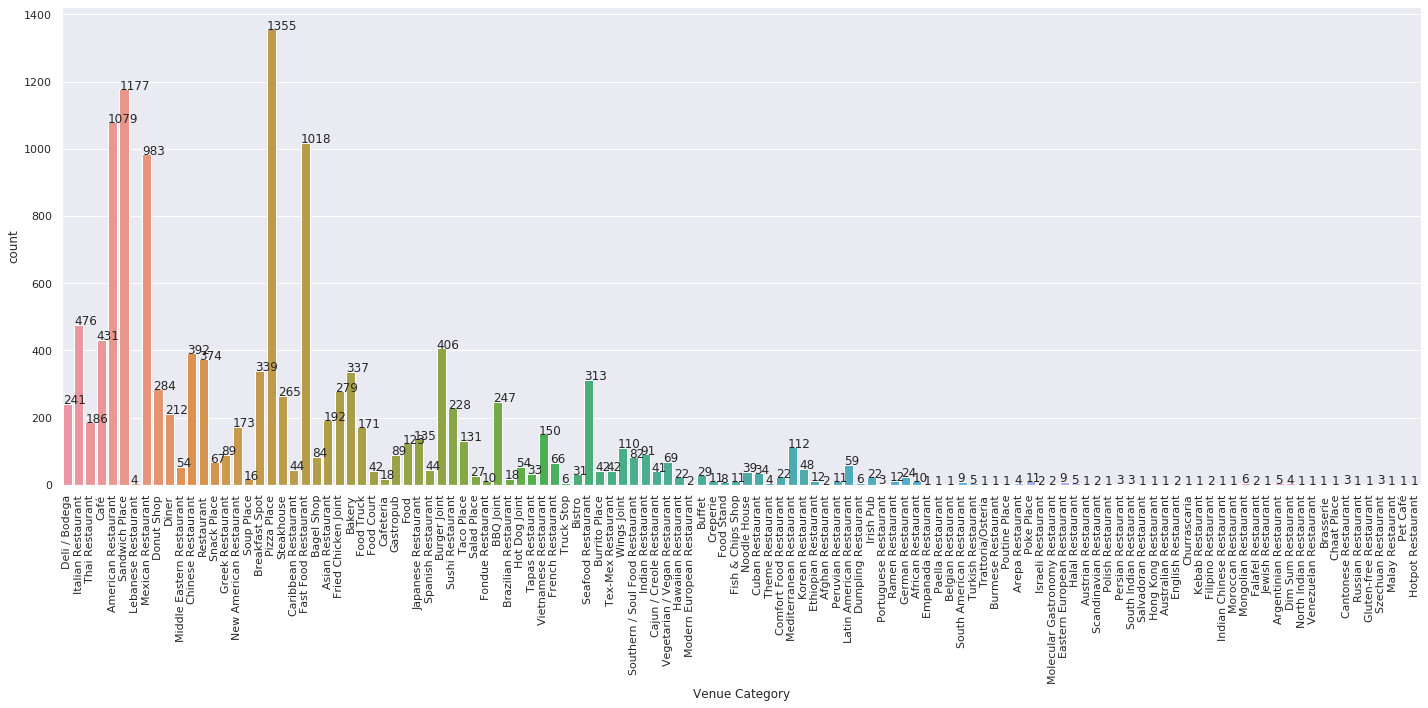

In [95]:
fig, ax = plt.subplots(figsize = (20,10))
sns.countplot(x="Venue Category", data=food_venues)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()

for p in ax.patches:
    x = p.get_x()
    y = p.get_y() + p.get_height()
    ax.annotate(p.get_height(), (x, y))

plt.show()

In [96]:
# Find most common venue category for each city

food_venues_onehot = pd.get_dummies(food_venues[['Venue Category']], prefix="", prefix_sep="")

food_venues_onehot['Area'] = food_venues['Area']

fixed_columns = [food_venues_onehot.columns[-1]] + list(food_venues_onehot.columns[:-1])
food_venues_onehot = food_venues_onehot[fixed_columns]

venues_grouped = food_venues_onehot.groupby('Area').mean().reset_index() # need to group with totals, not frequencis. ORRR maybe i can use frequencies
venues_grouped.set_index('Area', inplace=True)
venues_grouped

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,...,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Trattoria/Osteria,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
Area,,,,,,,,,,,,,,,,,,,,,
"Akron, OH",0.0,0.00,0.077778,0.0,0.0,0.011111,0.0,0.0,0.000000,0.011111,...,0.000000,0.033333,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.000000
"Albuquerque, NM",0.0,0.00,0.080000,0.0,0.0,0.020000,0.0,0.0,0.010000,0.000000,...,0.000000,0.000000,0.0,0.0,0.010000,0.0,0.00000,0.0,0.010000,0.000000
"Allentown, NJ",0.0,0.00,0.055556,0.0,0.0,0.000000,0.0,0.0,0.000000,0.013889,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.000000
"Amarillo, TX",0.0,0.00,0.112903,0.0,0.0,0.048387,0.0,0.0,0.048387,0.000000,...,0.000000,0.048387,0.0,0.0,0.000000,0.0,0.00000,0.0,0.016129,0.000000
"Arcadia, FL",0.0,0.00,0.103448,0.0,0.0,0.000000,0.0,0.0,0.034483,0.000000,...,0.034483,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.034483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Wichita Falls, TX",0.0,0.00,0.060241,0.0,0.0,0.012048,0.0,0.0,0.036145,0.000000,...,0.012048,0.012048,0.0,0.0,0.012048,0.0,0.00000,0.0,0.000000,0.024096
"Wichita, KS",0.0,0.00,0.060976,0.0,0.0,0.012195,0.0,0.0,0.048780,0.000000,...,0.000000,0.012195,0.0,0.0,0.000000,0.0,0.02439,0.0,0.085366,0.000000
"Worcester, MA",0.0,0.01,0.100000,0.0,0.0,0.020000,0.0,0.0,0.020000,0.000000,...,0.000000,0.010000,0.0,0.0,0.000000,0.0,0.02000,0.0,0.020000,0.010000


In [97]:
most_common_venue = pd.DataFrame(columns = ['Most common venue category',
                                           'Venue frequency'])

for i in range(0, len(venues_grouped.index)):
    most_common_venue.loc[i] = [venues_grouped.idxmax(axis=1)[i]] + [venues_grouped.max(axis=1)[i]]

most_common_venue.set_index(venues_grouped.index, inplace = True)

most_common_venue

,Most common venue category,Venue frequency
Area,,
"Akron, OH",Sandwich Place,0.133333
"Albuquerque, NM",Mexican Restaurant,0.160000
"Allentown, NJ",Italian Restaurant,0.180556
"Amarillo, TX",Mexican Restaurant,0.193548
"Arcadia, FL",Mexican Restaurant,0.137931
...,...,...
"Wichita Falls, TX",Fast Food Restaurant,0.144578
"Wichita, KS",Mexican Restaurant,0.109756
"Worcester, MA",American Restaurant,0.100000


In [98]:
# Bringing all data into 1 dataset

total_data = pd.merge(data, most_common_venue, left_index=True, right_index=True)
total_data

,Normal weight,Overweight,Obese,Latitude,Longitude,Most common venue category,Venue frequency
Area,,,,,,,
"Akron, OH",38.200001,32.500000,29.299999,41.0798,-81.5219,Sandwich Place,0.133333
"Albuquerque, NM",43.299999,34.900002,21.700001,35.1053,-106.6464,Mexican Restaurant,0.160000
"Allentown, NJ",37.500000,33.500000,29.000000,40.1777,-74.5873,Italian Restaurant,0.180556
"Amarillo, TX",35.000000,36.299999,28.700001,35.1989,-101.8310,Mexican Restaurant,0.193548
"Arcadia, FL",32.200001,33.700001,34.099998,27.2214,-81.8587,Mexican Restaurant,0.137931
...,...,...,...,...,...,...,...
"Wichita Falls, TX",32.900002,39.200001,27.900000,33.9072,-98.5290,Fast Food Restaurant,0.144578
"Wichita, KS",38.500000,34.400002,27.100000,37.6897,-97.3441,Mexican Restaurant,0.109756
"Worcester, MA",39.099998,35.799999,25.200001,42.2705,-71.8079,American Restaurant,0.100000


## Step 4: Attempt to find relationship between restaurant type & obesity rate

In [99]:
# Normalize data

total_data['Venue frequency'] = total_data['Venue frequency']*100
total_data

,Normal weight,Overweight,Obese,Latitude,Longitude,Most common venue category,Venue frequency
Area,,,,,,,
"Akron, OH",38.200001,32.500000,29.299999,41.0798,-81.5219,Sandwich Place,13.333333
"Albuquerque, NM",43.299999,34.900002,21.700001,35.1053,-106.6464,Mexican Restaurant,16.000000
"Allentown, NJ",37.500000,33.500000,29.000000,40.1777,-74.5873,Italian Restaurant,18.055556
"Amarillo, TX",35.000000,36.299999,28.700001,35.1989,-101.8310,Mexican Restaurant,19.354839
"Arcadia, FL",32.200001,33.700001,34.099998,27.2214,-81.8587,Mexican Restaurant,13.793103
...,...,...,...,...,...,...,...
"Wichita Falls, TX",32.900002,39.200001,27.900000,33.9072,-98.5290,Fast Food Restaurant,14.457831
"Wichita, KS",38.500000,34.400002,27.100000,37.6897,-97.3441,Mexican Restaurant,10.975610
"Worcester, MA",39.099998,35.799999,25.200001,42.2705,-71.8079,American Restaurant,10.000000


In [100]:
train_data = total_data[0:120]
test_data = total_data[121:160]

# x = train_data[['Obese', 'Venue frequency']]
# y = train_data['Most common venue category']
# x_test = test_data[['Obese', 'Venue frequency']]
# y_test = test_data['Most common venue category']

x = train_data[['Obese', 'Venue frequency', 'Latitude', 'Longitude']]
y = train_data['Most common venue category']
x_test = test_data[['Obese', 'Venue frequency', 'Latitude', 'Longitude']]
y_test = test_data['Most common venue category']

K        18.000000
Score     0.461538
Name: 18, dtype: float64

K        19.000000
Score     0.461538
Name: 19, dtype: float64

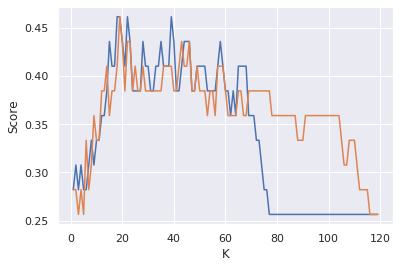

In [101]:
# KN algorithm

# find optimal k
scores = pd.DataFrame(columns=['K', 'Score'])
for i in range(1, 120):
    kn = KNeighborsClassifier(n_neighbors=i)
    kn.fit(x, y)
    scores.loc[i] = [i] + [kn.score(x_test, y_test)]

sns.lineplot(x="K", y="Score", data=scores)

scores2 = pd.DataFrame(columns=['K', 'Score'])
for i in range(1, 120):
    kn = KNeighborsClassifier(n_neighbors=i, weights='distance')
    kn.fit(x, y)
    scores2.loc[i] = [i] + [kn.score(x_test, y_test)]

sns.lineplot(x="K", y="Score", data=scores2)

display(scores.loc[scores['Score'].idxmax()], scores2.loc[scores2['Score'].idxmax()])

In [102]:
# Train the model on 2/3 of the data, and test on 1/3

kn = KNeighborsClassifier(n_neighbors=18)
kn.fit(x, y)
kn.score(x_test, y_test)

0.46153846153846156

In [103]:
# Using Naive Bayes classifiers

clf = GaussianNB()
clf.fit(x, y)
clf.score(x_test, y_test)

0.38461538461538464

In [104]:
# Decision tree classifier

dt = DecisionTreeClassifier(random_state=0)
dt.fit(x, y)
dt.score(x_test, y_test)

0.28205128205128205

In [105]:
# Evaluating the KNN algorithm

y_pred = kn.predict(x_test)
y_true = y_test

# Jaccard index
display(jaccard_score(y_true, y_pred, average = None))

# F1 score
f1_score(y_true, y_pred, average = None)

array([0.        , 0.        , 0.        , 0.28571429, 0.46153846,
       0.44444444, 0.22222222, 0.        ])

array([0.        , 0.        , 0.        , 0.44444444, 0.63157895,
       0.61538462, 0.36363636, 0.        ])